In [1]:
import subprocess
from matplotlib.patches import Rectangle
from tqdm import tqdm
import straw
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy import ndimage
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def generate_arrowhead_output(
        file_path, normalisation, chromosome, resolution, window=2000, output_folder=r'Data\arrowhead_output'):

    java_command = [
        'java',
        '-jar', r'uicer_tools_1.22.01.jar',
        'arrowhead',
        '-k', normalisation,
        '-r', str(resolution),
        '-c', str(chromosome),
        '-m', str(window),
        '--ignore-sparsity',
        file_path,
        output_folder
    ]

    result = subprocess.run(java_command, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Execution failed:\n{result.stderr}")
    else:
        print(f"Execution succeeded:\n{result.stdout}")
    
    return output_folder + rf'\{resolution}_blocks.bedpe'

def read_arrowhead(file_path, resolution):

    with open(file_path, 'r') as f:
        lines = f.readlines()
    lines = [line.strip().split('\t') for line in lines]

    df = pd.DataFrame(lines[2:], columns=lines[0])
    df['x1'] = df['x1'].astype(int) // resolution
    df['x2'] = df['x2'].astype(int) // resolution
    df.drop(columns=['y2', 'name', 'strand1', 'strand2'], inplace=True)

    df = df.rename(columns={'x1': 'start', 'x2': 'stop', 'y1': 'tad_size'})

    df = df.sort_values(by=['start', 'stop'])
    df = df.reset_index(drop=True)
    
    df['tad_size'] = df['stop'] - df['start']
    
    return df

def get_hic_df(normalisation, file_path, chromosome_1, chromosome_2, resolution, length_unit='BP'):
    
    df = straw.straw(
        infile=file_path, norm=normalisation, chr1loc=chromosome_1, chr2loc=chromosome_2, unit=length_unit, binsize=resolution)
    df = pd.DataFrame(df).transpose()
    df.columns = ['x', 'y', 'count']
    df['x'] = df['x'].astype(int) // resolution
    df['y'] = df['y'].astype(int) // resolution
    
    df = df.dropna()

    return df

def draw_contact_matrix_with_boundaries(matrix_df, tad_df, smooth=1):

    contact_matrix = matrix_df.pivot_table(index='x', columns='y', values='count', fill_value=0)
    contact_matrix = ndimage.uniform_filter(contact_matrix, smooth)

    sns.set_theme(rc={'figure.figsize': (10, 10)})

    ax = sns.heatmap(contact_matrix, cbar=False, vmin=0, vmax=contact_matrix.max(), square=True, norm=LogNorm(), cmap='Reds')

    for index, row in tad_df.iterrows():
        start_idx = row['start']
        stop_idx = row['stop']

        rect = Rectangle((start_idx, start_idx), stop_idx - start_idx, stop_idx - start_idx,
                         linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
        ax.add_patch(rect)

    plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_visible(True)
    plt.gca().axes.get_yaxis().set_visible(True)
    plt.show()

def draw_contact_matrix_with_boundries(matrix_df, tad_boundaries):
    contact_matrix = matrix_df.pivot_table(index='x', columns='y', values='count', fill_value=0)
    matrix = ndimage.uniform_filter(contact_matrix, 1)

    sns.set_theme(rc={'figure.figsize':(4, 4)})
    sns.heatmap(matrix, cbar=False, vmin=0, square=True, norm=LogNorm(), cmap='Reds')
    for boundary in tad_boundaries:
        plt.axvline(x=boundary, color='blue', linestyle='--')
        plt.axhline(y=boundary, color='blue', linestyle='--')
    plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(True)
    plt.show()
    
def generate_txt_from_hic(
        normalisation, chromosome, resolution, file_name, 
        path_hic = r'Data\GSE63525_GM12878_diploid_maternal.hic', 
        output_folder = r'Data' + '\\'):

    java_command = [
        "java", 
        "-jar", 
        r"juicer_tools_1.22.01.jar",
        "dump", "observed",
        normalisation,
        path_hic,
        str(chromosome), str(chromosome), 
        "BP", 
        str(resolution),
        output_folder + file_name
    ]

    result = subprocess.run(java_command, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Execution failed:\n{result.stderr}")
    else:
        print(f"Execution succeeded:\n{result.stdout}")
        
    return output_folder + file_name

def generate_spectral_output(
        path_txt_file, resolution, output_name, window = 25, min_size = 5):

    r_command = [
        "Rscript",
        r"get_tads.R",
        path_txt_file,
        str(resolution),
        r'\Data' + '\\' + output_name,
        str(min_size),
        str(window)
    ]
    # print(" ".join(r_command))
    try:
        result = subprocess.run(r_command, capture_output=True, text=True)
        print("R script executed successfully")
        print("Standard Output:", result.stdout)
        print("Standard Error:", result.stderr)
    except subprocess.CalledProcessError as e:
        print("An error occurred while executing the R script")
        print("Return Code:", e.returncode)
        print("Output:", e.output)
        print("Error:", e.stderr)
    
    return r'\Data' + '\\' + output_name

## Files and paths

In [3]:
hic_file_path = r"\Data\GSE63525_GM12878_diploid_maternal.hic"
resolution = 100000
chromosome = 11

## Hic dataframe

In [10]:
hic_df = get_hic_df('KR', hic_file_path, str(chromosome), str(chromosome), resolution)

HiC version:  7


In [11]:
hic_df

,x,y,count
0,1,1,4423.121924
1,1,2,1272.632636
2,2,2,2413.424026
3,1,3,803.390611
4,2,3,1649.724597
...,...,...,...
604972,1345,1349,123.368984
604973,1346,1349,200.207491
604974,1347,1349,340.328482
604975,1348,1349,593.784030


## Our model

In [ ]:
class Model:

    def __init__(self):
        self.data = None

    ###########################################################################################

    def read_data(self, paht_to_file, chromosome, resolution, smoothing, smoothing_param):

        def get_df(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution):
            # Data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
            # GSE63525_GM12878_diploid_maternal.hic
            df = straw.straw(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution)
            # example values: "KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000

            # Transforming the list to a data frame with three columns.
            # Origininally the raed data is a list of three lists,
            # each with the same length (list of x, y and counts).
            df = pd.DataFrame(df).transpose()
            df.columns = ['x', 'y', 'count']

            return df

        def is_symmetric(matrix):
            """
            Check if a matrix is symmetric.

            Parameters:
                matrix (list of lists): The input matrix.

            Returns:
                bool: True if the matrix is symmetric, False otherwise.
            """
            n = len(matrix)
            if n != len(matrix[0]):
                return False  # Matrix is not square, so it can't be symmetric

            for i in range(n):
                for j in range(i + 1, n):
                    if matrix[i][j] != matrix[j][i]:
                        return False  # If corresponding elements are not equal, matrix is not symmetric

            return True

        def make_symmetric(matrix):
            """
            Make a matrix symmetric by copying the lower triangle to the upper triangle.

            Parameters:
                matrix (list of lists): The input matrix.

            Returns:
                list of lists: The corrected symmetric matrix.
            """
            n = len(matrix)
            if n != len(matrix[0]):
                raise ValueError("Input matrix is not square")

            for i in range(n):
                for j in range(i + 1, n):
                    matrix[j][i] = matrix[i][j]

            return matrix

        def median_filtering(matrix, size=3):
            """
            Apply median filtering to a sparse matrix.

            Parameters:
                matrix (numpy.ndarray): The input matrix.
                size (int): The size of the median filter kernel.

            Returns:
                numpy.ndarray: The smoothed matrix.
            """
            smoothed_matrix = ndimage.median_filter(matrix, size=size)
            return smoothed_matrix

        def gaussian_smoothing(matrix, sigma=1):
            """
            Apply Gaussian smoothing to a sparse matrix.

            Parameters:
                matrix (numpy.ndarray): The input matrix.
                sigma (float): Standard deviation of the Gaussian filter.

            Returns:
                numpy.ndarray: The smoothed matrix.
            """
            smoothed_matrix = ndimage.gaussian_filter(matrix, sigma=sigma)
            return smoothed_matrix

        def mean_smoothing(matrix, size=1):
            """
            Apply Mean smoothing to a sparse matrix.

            Parameters:
                matrix (numpy.ndarray): The input matrix.
                sigma (float): Standard deviation of the Gaussian filter.

            Returns:
                numpy.ndarray: The smoothed matrix.
            """
            smoothed_matrix = ndimage.uniform_filter(matrix, size)
            return smoothed_matrix

        def general_information_about_data(df):
            print(f'Number of rows: {len(df)}')
            print(f"Number of unique x and y values: {df['x'].nunique()}, {df['y'].nunique()}")
            print(f"Mean interactions per fragment {df['count'].mean()}")
            print(f"Median of interactions per fragment {df['count'].median()}")

        df = get_df("KR", paht_to_file, chromosome, chromosome, "BP", resolution)
        # print('df', type(df), (len(df.index), len(df.columns)))
        max_index = int(max(np.max(df['x']), np.max(df['y'])))
        # print(np.max(df['count']))

        #
        list_of_ind = [i * resolution for i in range(0, max_index // resolution + 1)]
        list_of_unique_ind = list(set(df['x'].unique()).union(set(df['y'].unique())))
        list_of_missing_ind = list(set(list_of_ind) - set(list_of_unique_ind))
        # print('list_of_missing_ind', list_of_missing_ind)

        for ind in list_of_missing_ind:
            df.loc[len(df.index)] = [ind, ind, 0]

        # if in df there are rows with the same pair of x and y, we sum them
        df = df.groupby(['x', 'y']).sum().reset_index()

        # general_information_about_data(df)
        # a = df.pivot(index='x', columns='y', values='count').to_numpy()
        # print('a', type(a), a.shape)
        data = np.nan_to_num(df.pivot(index='x', columns='y', values='count').to_numpy(),
                             copy=True, nan=0.0, posinf=None, neginf=None)

        # cut to square
        data = data[:min(data.shape[0], data.shape[1]), :min(data.shape[0], data.shape[1])]

        # print('data_not_square', type(data_not_square), data_not_square.shape)
        # print(data_not_square)
        # data = np.zeros((max(data_not_square.shape), max(data_not_square.shape)))
        # # print('data', type(data), data.shape)
        # data[:data_not_square.shape[0], :data_not_square.shape[1]] = data_not_square

        # print('data', type(data), data.shape)

        if not is_symmetric(data):
            data = make_symmetric(data)

        # print('data2', type(data), data)
        data = data + data.T - np.diag(data.diagonal())

        if smoothing == 1:
            data = median_filtering(data, smoothing_param)
        elif smoothing == 2:
            data = gaussian_smoothing(data, smoothing_param)
        elif smoothing == 3:
            data = mean_smoothing(data, smoothing_param)
        else:
            print('Selected no smoothing. To select:\n\
                    median_filtering - type 1\n\
                    gaussian_smoothing - type 2\n\
                    mean_smoothing - type 3.'
                  )

        if not is_symmetric(data):
            data = make_symmetric(data)

        self.data = data

    ###########################################################################################

    def draw_contact_matrix(self, tad_boundaries, title):
        sns.set_theme(rc={'figure.figsize':(4, 4)})
        sns.heatmap(
            self.data, cbar=False, vmin=0, square=True,
            norm=LogNorm(vmin=np.quantile(self.data.flatten(), 0.1), vmax=np.quantile(self.data.flatten(), 0.99)),
            cmap='Reds')
        for i in range(len(tad_boundaries)):
            start = tad_boundaries[i][0]
            end = tad_boundaries[i][1]
            rect = Rectangle((start, start), end - start, end - start, linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
            plt.gca().add_patch(rect)
            rect = Rectangle((start, start), end - start, end - start, linewidth=1, edgecolor='lightgreen', facecolor='none', linestyle='--')
            plt.gca().add_patch(rect)

        plt.gca().invert_yaxis()
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(True)
        plt.title(title)
        plt.show()

    ###########################################################################################

    # def draw_contact_matrix_with_boundries(self, tad_boundaries):
    #     sns.set_theme(rc={'figure.figsize':(4, 4)})
    #     sns.heatmap(self.data, cbar=False, vmin=0, square=True, norm=LogNorm(), cmap='Reds')
    #     for boundary in tad_boundaries:
    #         plt.axvline(x=boundary, color='blue', linestyle='--')
    #         plt.axhline(y=boundary, color='blue', linestyle='--')
    #     plt.gca().invert_yaxis()
    #     plt.gca().axes.get_xaxis().set_visible(False)
    #     plt.gca().axes.get_yaxis().set_visible(True)
    #     plt.show()

    def draw_contact_matrix_with_boundaries(self, tad_boundaries, ax, title):

        sns.heatmap(
            self.data, cbar=False,square=True,
            norm=LogNorm(vmin=np.quantile(self.data.flatten(), 0.1), vmax=np.quantile(self.data.flatten(), 0.99)),
            cmap="Reds", ax=ax)

        for i in range(len(tad_boundaries)):
            start = tad_boundaries[i][0]
            end = tad_boundaries[i][1]
            rect = Rectangle((start, start), end - start, end - start, linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            rect = Rectangle((start, start), end - start, end - start, linewidth=1, edgecolor='lightgreen', facecolor='none', linestyle='--')
            ax.add_patch(rect)

        ax.set_title(title)
        ax.invert_yaxis()
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(True)

    def plot_multiple_heatmaps(self, tad_boundaries_list, title_list=None):
        fig, axs = plt.subplots(1, len(tad_boundaries_list), figsize=(12, 4))

        for i, tad_boundaries in enumerate(tad_boundaries_list):
            self.draw_contact_matrix_with_boundaries(tad_boundaries, axs[i], title_list[i] if title_list else None)

        plt.show()

    ###########################################################################################

    def get_diagonal_averages(self, max_r):
        """
        Compute the average of sums of elements inside square submatrices along the diagonal of a given matrix
        per element in the submatrix.

        Parameters:
            matrix (numpy.ndarray): The input matrix.
            r (int): The size of the square submatrix.

        Returns:
            list: A list of sums of elements inside each square submatrix along the diagonal.
        """

        result = []

        for r in range(1, max_r):
            sums = []
            n = self.data.shape[0]

            for i in range(0, n - r + 1):
                submatrix = self.data[i:i+r, i:i+r]
                submatrix_sum = np.sum(submatrix)/(r*r)
                sums.append(submatrix_sum)

            result.append(sums)

        return result

    ###########################################################################################

    def get_tad_boundaries(self, max_num_of_tads, min_tad_size, smoothing_param, max_r, sums):

        def process_lists(list_of_lists, threshold_strength=1):
            """
            Process each list in the list of lists:
            1. Separate values greater than the mean of the list.
            2. Find continuous sequences where more than 10% of all values are present.
            3. Find the maximum value for such sequences.
            4. Place the indexes corresponding to max values in a list.
            5. Place these lists in a list and return the result.

            Parameters:
                list_of_lists (list of lists): The input list of lists.

            Returns:
                list: A list containing lists of indexes corresponding to maximum values for each list.
            """
            result = []

            # use tqdm to show progress bar
            for lst in tqdm(list_of_lists):
                threshold = np.mean(lst)*threshold_strength
                continuous_sequences_max = []

                # Separate values greater than the mean (rest set to 0)
                for i in range(len(lst)):
                    if lst[i] < threshold:
                        lst[i] = 0

                # Find continuous sequences (separator is 0) where more than 10% of all values are present
                continuous_sequences = [0] * len(lst)

                sequence_length = math.floor(len(lst)*0.1+1)
                for i in range(len(lst) - sequence_length + 1):
                    if all(lst[i+j] != 0 for j in range(sequence_length)):
                        continuous_sequences[i:i+sequence_length] = lst[i:i+sequence_length]


                # Fina max values in sequences (separated by 0) and  change non-max values to 0
                start = 0
                for i in range(len(continuous_sequences)):
                    if continuous_sequences[i] == 0:
                        if start != i:
                            max_value = max(continuous_sequences[start:i])
                            continuous_sequences_max.extend([0 if val != max_value else val for val in continuous_sequences[start:i]])
                        continuous_sequences_max.append(0)  # Append the 0 separator
                        start = i + 1
                    elif i == len(continuous_sequences) - 1:
                        max_value = max(continuous_sequences[start:i + 1])
                        continuous_sequences_max.extend([0 if val != max_value else val for val in continuous_sequences[start:i + 1]])

                # Find all indexes of non-0 values
                result.append([i for i, val in enumerate(continuous_sequences_max) if val != 0])
            return result

        def create_result_array(IN, tad_num, dist, information = False):
            """
            Create a RESULT array with S elements from the input array IN,
            maintaining the distance constraint K as described.

            Parameters:
            IN (list): The input array.
            tad_num (int): The number of elements required in the RESULT array.
            dist (int): The distance constraint between elements in the RESULT array.

            Returns:
            list: The resulting array.
            """
            RESULT = []

            for i in range(len(IN)):
                RESULT.append(IN[i])

                if len(RESULT) >= 2:
                    RESULT = sorted(RESULT)
                    l = len(RESULT)
                    j = 1
                    while j < l:
                        if abs(RESULT[j-1] - RESULT[j]) <= dist:
                            RESULT[j-1] = min([RESULT[j-1], RESULT[j]])
                            RESULT.pop(j)
                            l -= 1
                            j -= 1
                        j += 1
                if len(RESULT) == tad_num:
                    if information:
                        print(f'Found {tad_num} TADs')
                    return RESULT

            if information:
                print(f'Found {len(RESULT)} TADs')
            return RESULT

        tad_boundaries = create_result_array(
            [value[0] for value in sorted(Counter([value for sub_list in process_lists(sums)
                                                   for value in sub_list]).items(),
                                          key=lambda x: x[1], reverse=True)],
            max_num_of_tads, min_tad_size, True)

        return tad_boundaries

In [22]:
model = Model()
# model parameters
smoothing = 2
smoothing_param = 10
max_num_of_tads = 50
min_tad_size = 0.01 * max(hic_df['x'])

In [23]:
model.read_data(hic_file_path, str(chromosome), resolution, smoothing, smoothing_param)

HiC version:  7


In [24]:
max_r = int(np.floor(len(model.data)/2))
list_of_averages = model.get_diagonal_averages(max_r)
tad_boundaries_model = model.get_tad_boundaries(max_num_of_tads, min_tad_size, smoothing_param, max_r, list_of_averages) + [len(model.data) - 1]
tad_boundaries_model = [(tad_boundaries_model[i], tad_boundaries_model[i+1]) for i in range(len(tad_boundaries_model) - 1)]
print(tad_boundaries_model)

100%|██████████| 674/674 [00:05<00:00, 133.15it/s]

Found 12 TADs
[(0, 36), (36, 50), (50, 210), (210, 561), (561, 576), (576, 592), (592, 621), (621, 635), (635, 676), (676, 901), (901, 964), (964, 1349)]


In [ ]:
# for various resolutions
resolutions = [100000, 250000]
results = []

hic_file_path = r"Data\GSE63525_GM12878_diploid_maternal.hic"
chrom = [11, 17, 22]
smoothing = 3
smoothing_param = 10
max_num_of_tads = 50

for chromosome in chrom:
    for res in resolutions:
        print(chromosome, res)
        hic_df = get_hic_df('KR', hic_file_path, str(chromosome), str(chromosome), res)
        min_tad_size = 0.01 * max(hic_df['x'])
        print('done')
        model = Model()
        model.read_data(hic_file_path, str(chromosome), res, smoothing, smoothing_param)
        print('done')
        max_r = int(np.floor(len(model.data)/2))
        list_of_averages = model.get_diagonal_averages(max_r)
        tad_boundaries_model = model.get_tad_boundaries(max_num_of_tads, min_tad_size, smoothing_param, max_r, list_of_averages) + [len(model.data) - 1]
        tad_boundaries_model = \
            [(tad_boundaries_model[i], tad_boundaries_model[i+1]) for i in range(len(tad_boundaries_model) - 1)]
        print(res, tad_boundaries_model)
        model.draw_contact_matrix(tad_boundaries_model, f'Model - {chromosome} - {res}')
        results.append(tad_boundaries_model)
plt.show()

## Arrowhead

In [25]:
# generate arrowhead output
arrowhead_file_path = generate_arrowhead_output(hic_file_path, 'KR', chromosome, resolution)

Execution succeeded:
WARN [2024-06-12T21:27:03,054]  [Globals.java:138] [main]  Development mode is enabled
Reading file: C:\Users\ola\Desktop\WB_proj\Data\GSE63525_GM12878_diploid_maternal.hic
Using 1 CPU thread(s)
max 1.0
100% 
18 features written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
18 domains written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
Arrowhead complete



In [26]:
# read arrowhead output
arrowhead_df = read_arrowhead(arrowhead_file_path, resolution)
arrowhead_df

,#chr1,start,stop,chr2,tad_size,score,color,score,uVarScore,lVarScore,upSign,loSign
0,11,41,80,11,39,.,"255,255,0",1.0753381786211489,0.0647647388643891,0.0581742025732082,0.81,0.5675
1,11,152,167,11,15,.,"255,255,0",0.894584692561989,0.059452135594492445,0.08042012924190144,0.515625,0.640625
2,11,206,221,11,15,.,"255,255,0",0.8829762702326511,0.06161234621052947,0.04477909560908362,0.609375,0.515625
3,11,228,262,11,34,.,"255,255,0",0.9497477342703282,0.057899067116876896,0.05656723534309301,0.696078431372549,0.565359477124183
4,11,311,323,11,12,.,"255,255,0",0.7788714481567991,0.06384722599168896,0.06524965503939702,0.5,0.5
5,11,330,365,11,35,.,"255,255,0",0.8616391116646094,0.09180746116471675,0.10359940297256268,0.5092592592592593,0.654320987654321
6,11,369,432,11,63,.,"255,255,0",1.3184983796010403,0.12222523259102039,0.13280407856694057,0.82421875,0.7578125
7,11,439,460,11,21,.,"255,255,0",1.035339793835697,0.054045791086093795,0.060978621053220564,0.7523875114784206,0.5922405876951331
8,11,571,588,11,17,.,"255,255,0",1.0171999943859846,0.07324830505587804,0.0583440712904999,0.7160493827160493,0.5925925925925926
9,11,613,639,11,26,.,"255,255,0",1.0291226780406013,0.08872482444215797,0.08788886080951502,0.6978021978021978,0.6648351648351648


In [17]:
# create list of TAD boundaries
tad_boundaries_arrowhead = [(arrowhead_df['start'][i], arrowhead_df['stop'][i]) for i in range(len(arrowhead_df))]
print('Number of TADs:', len(tad_boundaries_arrowhead))
print('Min size of TAD:', min(arrowhead_df['tad_size']))
print('Max size of TAD:', max(arrowhead_df['tad_size']))

Number of TADs: 18
Min size of TAD: 12
Max size of TAD: 63


## Spectral

In [18]:
txt_matrix_path = generate_txt_from_hic('KR', chromosome, resolution, 'matrix_to_text.txt')
spectral_csv = generate_spectral_output(txt_matrix_path, resolution, 'spectral_output.txt', 100, 14)

Execution succeeded:
WARN [2024-06-12T21:25:22,645]  [Globals.java:138] [main]  Development mode is enabled

R script executed successfully
Standard Output: $Level_1
# A tibble: 31 Ă— 5
     chr    start      end Sil_Score Level
   <dbl>    <dbl>    <dbl> <dbl[1d]> <dbl>
 1    11   100000  3800000     0.748     1
 2    11  3800000  8000000     0.614     1
 3    11  8000000 10800000     0.626     1
 4    11 10800000 13500000     0.724     1
 5    11 13500000 18900000     0.302     1
 6    11 18900000 22900000     0.449     1
 7    11 22900000 27600000     0.589     1
 8    11 27600000 31100000     0.582     1
 9    11 31100000 32800000     0.829     1
10    11 32800000 36800000     0.493     1
# â„ą 21 more rows


Standard Error: 
Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt

Converting to n x n matrix
Matrix dimensions: 1349x1349



In [19]:
spectral_df = pd.read_csv(spectral_csv, sep=',')
spectral_df['start'] = (spectral_df['Level_1.start'] // resolution) - 1
spectral_df['end'] = (spectral_df['Level_1.end'] // resolution) - 1
spectral_df = spectral_df[['start', 'end']]
spectral_df['tad_size'] = spectral_df['end'] - spectral_df['start']
spectral_df

,start,end,tad_size
0,0,37,37
1,37,79,42
2,79,107,28
3,107,134,27
4,134,188,54
5,188,228,40
6,228,275,47
7,275,310,35
8,310,327,17
9,327,367,40


In [20]:
tad_boundaries_spectral = [(spectral_df['start'][i], spectral_df['end'][i]) for i in range(len(spectral_df))]
print('Number of TADs:', len(tad_boundaries_spectral))
print('Min size of TAD:', np.min(spectral_df['tad_size']))
print('Max size of TAD:', np.max(spectral_df['tad_size']))

Number of TADs: 31
Min size of TAD: 17
Max size of TAD: 74


## Save to pickle

In [28]:
import pickle

chrom = [16, 8, 13, 21, 19]
# chrom = np.random.choice(chrom, 5, replace=False)
print(chrom)

for chromosome in tqdm(chrom):
    hic_df = get_hic_df('KR', hic_file_path, str(chromosome), str(chromosome), resolution)
    model = Model()
    # model parameters
    smoothing = 2
    smoothing_param = 10
    max_num_of_tads = 50
    min_tad_size = 0.01 * max(hic_df['x'])
    model.read_data(hic_file_path, str(chromosome), resolution, smoothing, smoothing_param)
    max_r = int(np.floor(len(model.data)/2))
    list_of_averages = model.get_diagonal_averages(max_r)
    tad_boundaries_model = model.get_tad_boundaries(max_num_of_tads, min_tad_size, smoothing_param, max_r, list_of_averages) + [len(model.data) - 1]
    tad_boundaries_model = [(tad_boundaries_model[i], tad_boundaries_model[i+1]) for i in range(len(tad_boundaries_model) - 1)]
    
    arrowhead_file_path = generate_arrowhead_output(hic_file_path, 'KR', chromosome, resolution)
    arrowhead_df = read_arrowhead(arrowhead_file_path, resolution)
    tad_boundaries_arrowhead = [(arrowhead_df['start'][i], arrowhead_df['stop'][i]) for i in range(len(arrowhead_df))]
    
    txt_matrix_path = generate_txt_from_hic('KR', chromosome, resolution, 'matrix_to_text.txt')
    spectral_csv = generate_spectral_output(txt_matrix_path, resolution, 'spectral_output.txt', 100, 14)
    spectral_df = pd.read_csv(spectral_csv, sep=',')
    spectral_df['start'] = (spectral_df['Level_1.start'] // resolution) - 1
    spectral_df['end'] = (spectral_df['Level_1.end'] // resolution) - 1
    spectral_df = spectral_df[['start', 'end']]
    spectral_df['tad_size'] = spectral_df['end'] - spectral_df['start']
    tad_boundaries_spectral = [(spectral_df['start'][i], spectral_df['end'][i]) for i in range(len(spectral_df))]

    with open(rf'Data\res{resolution}{chromosome}.pkl', 'wb') as f:
        pickle.dump([tad_boundaries_model, tad_boundaries_arrowhead, tad_boundaries_spectral], f)

[16, 8, 13, 21, 19]


  0%|          | 0/5 [00:00<?, ?it/s]

HiC version:  7


 20%|██        | 1/5 [00:05<00:20,  5.03s/it]

Execution succeeded:
WARN [2024-06-13T00:37:45,875]  [Globals.java:138] [main]  Development mode is enabled
Reading file: C:\Users\ola\Desktop\WB_proj\Data\GSE63525_GM12878_diploid_maternal.hic
Using 1 CPU thread(s)
max 1.0
100% 
14 features written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
14 domains written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
Arrowhead complete

HiC version:  7


 40%|████      | 2/5 [00:23<00:39, 13.04s/it]

Execution succeeded:
WARN [2024-06-13T00:37:58,202]  [Globals.java:138] [main]  Development mode is enabled
Reading file: C:\Users\ola\Desktop\WB_proj\Data\GSE63525_GM12878_diploid_maternal.hic
Using 1 CPU thread(s)
max 1.0
100% 
30 features written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
30 domains written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
Arrowhead complete

HiC version:  7


 60%|██████    | 3/5 [00:37<00:26, 13.36s/it]

Execution succeeded:
WARN [2024-06-13T00:38:11,625]  [Globals.java:138] [main]  Development mode is enabled
Reading file: C:\Users\ola\Desktop\WB_proj\Data\GSE63525_GM12878_diploid_maternal.hic
Using 1 CPU thread(s)
max 1.0
100% 
22 features written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
22 domains written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
Arrowhead complete

HiC version:  7


 80%|████████  | 4/5 [00:39<00:08,  8.92s/it]

Execution succeeded:
WARN [2024-06-13T00:38:20,913]  [Globals.java:138] [main]  Development mode is enabled
Reading file: C:\Users\ola\Desktop\WB_proj\Data\GSE63525_GM12878_diploid_maternal.hic
Using 1 CPU thread(s)
max 1.0
100% 
5 features written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
5 domains written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
Arrowhead complete

HiC version:  7


100%|██████████| 5/5 [00:42<00:00,  8.56s/it]

Execution succeeded:
WARN [2024-06-13T00:38:24,074]  [Globals.java:138] [main]  Development mode is enabled
Reading file: C:\Users\ola\Desktop\WB_proj\Data\GSE63525_GM12878_diploid_maternal.hic
Using 1 CPU thread(s)
max 1.0
100% 
6 features written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
6 domains written to file: C:\Users\ola\Desktop\WB_proj\Data\arrowhead_output\100000_blocks.bedpe
Arrowhead complete



In [29]:
# load pickle
import pickle
chrom = [16, 8, 13, 21, 19]
tads_model = []
tads_arrowhead = []
tads_spectral = []

for chromosome in chrom:
    with open(rf'Data\res{resolution}{chromosome}.pkl', 'rb') as f:
        tad_boundaries_model, tad_boundaries_arrowhead, tad_boundaries_spectral = pickle.load(f)
        tads_model.append(tad_boundaries_model)
        tads_arrowhead.append(tad_boundaries_arrowhead)
        tads_spectral.append(tad_boundaries_spectral)

## Wykresy

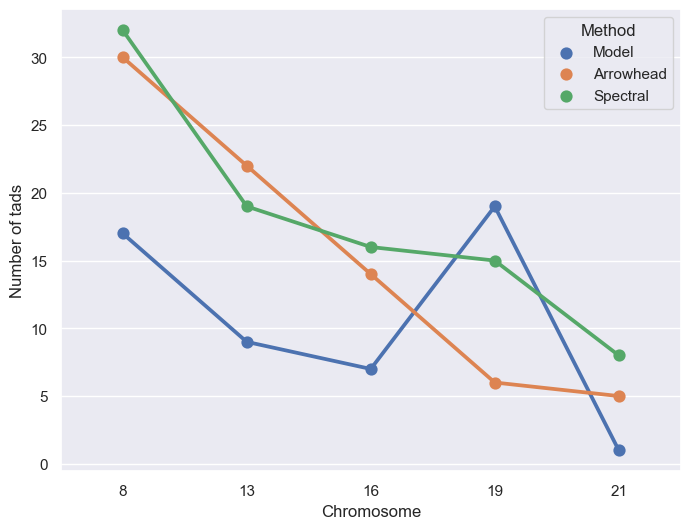

In [31]:
# x axis - chromosome, y axis - number of TADs, color - method

tad_counts = [len(tads_model[i]) for i in range(len(tads_model))] + \
                [len(tads_arrowhead[i]) for i in range(len(tads_arrowhead))] + \
                [len(tads_spectral[i]) for i in range(len(tads_spectral))]
methods = ['Model' for _ in range(len(tads_model))] + ['Arrowhead' for i in range(len(tads_arrowhead))] + \
            ['Spectral' for i in range(len(tads_spectral))]
chromosomes = list(chrom) * 3

df = pd.DataFrame({'Chromosome': chromosomes, 'Number of tads': tad_counts, 'Method': methods})

sns.set_theme(rc={'figure.figsize': (8, 6)})
sns.pointplot(x='Chromosome', y='Number of tads', hue='Method', data=df)
# sns.barplot(x='Chromosome', y='Number of tads', hue='Method', data=df)
plt.show()

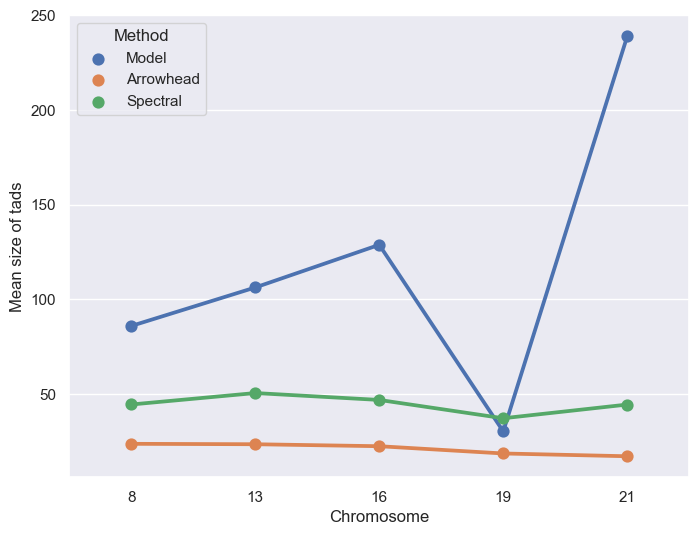

In [32]:
# x axis - chromosome, y axis - mean tad size, color - method

def get_mean_size(tads_list):
    sizes = [tad[1] - tad[0] for tad in tads_list]
    return sum(sizes)/len(sizes)

tad_counts = [get_mean_size(tads_model[i]) for i in range(len(tads_model))] + \
             [get_mean_size(tads_arrowhead[i]) for i in range(len(tads_arrowhead))] + \
             [get_mean_size(tads_spectral[i]) for i in range(len(tads_spectral))]
methods = ['Model' for _ in range(len(tads_model))] + ['Arrowhead' for i in range(len(tads_arrowhead))] + \
          ['Spectral' for i in range(len(tads_spectral))]
chromosomes = list(chrom) * 3

df = pd.DataFrame({'Chromosome': chromosomes, 'Mean size of tads': tad_counts, 'Method': methods})

sns.set_theme(rc={'figure.figsize': (8, 6)})
sns.pointplot(x='Chromosome', y='Mean size of tads', hue='Method', data=df)
plt.show()

19
HiC version:  7


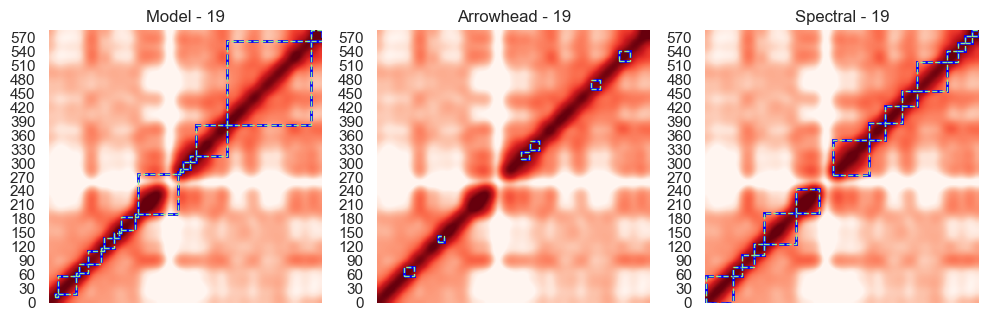

In [34]:
i = 4
print(chrom[i])
model = Model()
model.read_data(hic_file_path, str(chrom[i]), resolution, smoothing, smoothing_param)
model.plot_multiple_heatmaps([tads_model[i], tads_arrowhead[i], tads_spectral[i]], [f'Model - {chrom[i]}', f'Arrowhead - {chrom[i]}', f'Spectral - {chrom[i]}'])

### Wskaźnik TAD-adjR²


In [36]:
def calculate_tad_adj_r2(hi_c_data, tad_boundaries):
    def average_contact_frequency(matrix, start, end):
        if start >= end:
            return 0
        return np.mean(matrix[start:end, start:end])

    tad_means = []
    for start, end in tad_boundaries:
        tad_mean = average_contact_frequency(hi_c_data, start, end)
        tad_means.append(tad_mean)

    global_mean = np.mean(hi_c_data)

    sse_tads = 0
    sse_global = 0
    q = hi_c_data.shape[0]

    for i in range(q):
        for j in range(q):
            if i < j:
                is_in_tad = False
                for k, (start, end) in enumerate(tad_boundaries):
                    if start <= i < end and start <= j < end:
                        sse_tads += (hi_c_data[i, j] - tad_means[k]) ** 2
                        is_in_tad = True
                        break
                if not is_in_tad:
                    sse_tads += (hi_c_data[i, j] - global_mean) ** 2

                sse_global += (hi_c_data[i, j] - global_mean) ** 2

    p = len(tad_boundaries)

    if sse_global == 0:
        return float('inf')

    tad_adj_r2 = 1 - ((q - 1) * sse_tads) / ((q - p - 1) * sse_global)
    return tad_adj_r2

def model_output_to_tad_boundaries(output):
    return [(output[i], output[i+1]) for i in range(len(output) - 1)]

In [37]:
for i in range(len(chrom)):
    print(chrom[i])
    model = Model()
    model.read_data(hic_file_path, str(chrom[i]), resolution, smoothing, smoothing_param)
    print('Model:', round(calculate_tad_adj_r2(model.data, tads_model[i]), 4))
    print('Arrowhead:', round(calculate_tad_adj_r2(model.data, tads_arrowhead[i]), 4))
    print('Spectral:', round(calculate_tad_adj_r2(model.data, tads_spectral[i]), 4))

16
HiC version:  7
Model: 0.1672
Arrowhead: 0.1796
Spectral: nan
8
HiC version:  7
Model: 0.2701
Arrowhead: 0.2238
Spectral: 0.6034
13
HiC version:  7
Model: 0.315
Arrowhead: 0.2593
Spectral: 0.5849
21
HiC version:  7
Model: 0.0883
Arrowhead: 0.0928
Spectral: 0.5199
19
HiC version:  7
Model: 0.3142
Arrowhead: 0.0865
Spectral: 0.5488


### Wskaźnik MoC i DBI

In [14]:
def calculate_moc(tads_p, tads_q):
    
    def overlap_length(tad1, tad2):
        start1, end1 = tad1
        start2, end2 = tad2
        overlap = max(0, min(end1, end2) - max(start1, start2))
        return overlap

    N_P = len(tads_p)
    N_Q = len(tads_q)

    if N_P == 1 and N_Q == 1:
        return 1

    sum_overlap = 0
    for tad_p in tads_p:
        for tad_q in tads_q:
            F_ij = overlap_length(tad_p, tad_q)
            P_i = tad_p[1] - tad_p[0]
            Q_j = tad_q[1] - tad_q[0]
            sum_overlap += (F_ij ** 2) / (P_i * Q_j)

    moc_value = (1 / (np.sqrt(N_P * N_Q) - 1)) * (sum_overlap - 1)
    return moc_value

In [44]:
def calculate_centroid(matrix, tad_boundary):

    start, end = tad_boundary
    return np.mean(matrix[start:end, :], axis=0)

def calculate_d_i(matrix, tad_boundary, centroid):

    start, end = tad_boundary
    distances = [np.linalg.norm(matrix[i, :] - centroid) for i in range(start, end)]
    return np.mean(distances)

def calculate_distance_ij(centroid_i, centroid_j):

    return np.linalg.norm(centroid_i - centroid_j)

def calculate_dbi(matrix, tad_boundaries):

    n_tads = len(tad_boundaries)
    centroids = [calculate_centroid(matrix, tad_boundary) for tad_boundary in tad_boundaries]
    d_i_values = [calculate_d_i(matrix, tad_boundary, centroids[i]) for i, tad_boundary in enumerate(tad_boundaries)]

    S_ij = np.zeros((n_tads, n_tads))
    for i in range(n_tads):
        for j in range(n_tads):
            if i != j:
                S_ij[i, j] = (d_i_values[i] + d_i_values[j]) / calculate_distance_ij(centroids[i], centroids[j])

    dbi = np.mean([max(S_ij[i, :]) for i in range(n_tads)])
    return dbi


In [46]:
# Calculate MoC and DBI for the model output

for i in range(len(chrom)):
    model = Model()
    smoothing = 2
    smoothing_param = 10
    resolution = 100000
    model.read_data(hic_file_path, str(chrom[i]), resolution, smoothing, smoothing_param)
    print(f'MoC for arrowhead {chrom[i]}:', calculate_moc(tads_model[i], tads_arrowhead[i]))
    print(f'MoC for spectral {chrom[i]}:', calculate_moc(tads_model[i], tads_spectral[i]))
    print(f'DBI for model {chrom[i]}:', calculate_dbi(model.data, tads_model[i]))
    print(f'DBI for arrowhead {chrom[i]}:', calculate_dbi(model.data, tads_arrowhead[i]))
    print(f'DBI for spectral {chrom[i]}:', calculate_dbi(model.data, tads_spectral[i]))

HiC version:  7
MoC for arrowhead 16: 0.11586080603879381
MoC for spectral 16: 0.35949196006640544
DBI for model 16: 1.7423175805047513
DBI for arrowhead 16: 0.6348523419866022
DBI for spectral 16: nan
HiC version:  7
MoC for arrowhead 8: 0.14788557833095814
MoC for spectral 8: 0.428148411497974
DBI for model 8: 1.4175655041114763
DBI for arrowhead 8: 0.9891127607241194
DBI for spectral 8: 0.8169387461568249
HiC version:  7
MoC for arrowhead 13: 0.24180155308857298
MoC for spectral 13: 0.4404180924479116
DBI for model 13: 1.593298082701602
DBI for arrowhead 13: 1.2437772910903602
DBI for spectral 13: 0.9324192916138199
HiC version:  7
MoC for arrowhead 21: -0.6025314853503793
MoC for spectral 21: -0.029031439241636346
DBI for model 21: 0.0
DBI for arrowhead 21: 0.35380415809291776
DBI for spectral 21: 0.8876785157088839
HiC version:  7
MoC for arrowhead 19: 0.10152821551100982
MoC for spectral 19: 0.3837426493487666
DBI for model 19: 0.9023265233816987
DBI for arrowhead 19: 0.314482101

### Wskaźnik Delta Contact Count (DCC)

In [38]:
def calculate_contact_counts(matrix, tad_boundaries):

    total_inside_contacts = 0
    total_inside_pairs = 0

    total_between_contacts = 0
    total_between_pairs = 0

    for start_i, end_i in tad_boundaries:
        for j in range(start_i, end_i):
            for k in range(j + 1, end_i):
                total_inside_contacts += matrix[j, k]
                total_inside_pairs += 1

    for i in range(len(tad_boundaries)):
        start_i, end_i = tad_boundaries[i]
        for j in range(start_i, end_i):
            for k in range(0, start_i):
                total_between_contacts += matrix[j, k]
                total_between_pairs += 1
            for k in range(end_i, matrix.shape[1]):
                total_between_contacts += matrix[j, k]
                total_between_pairs += 1

    inside_contacts_mean = total_inside_contacts / total_inside_pairs if total_inside_pairs > 0 else 0
    between_contacts_mean = total_between_contacts / total_between_pairs if total_between_pairs > 0 else 0

    return inside_contacts_mean, between_contacts_mean

def delta_contact_count(matrix, tad_boundaries):
    in_mean, out_mean = calculate_contact_counts(matrix, tad_boundaries)
    dcc = in_mean - out_mean

    return dcc

In [43]:
# Calculate Delta Contact Count for the model output

for i in range(len(chrom)):
    model = Model()
    smoothing = 2
    smoothing_param = 10
    resolution = 100000
    model.read_data(hic_file_path, str(chrom[i]), resolution, smoothing, smoothing_param)
    print(f'Delta Contact Count for arrowhead {chrom[i]}:', round(delta_contact_count(model.data, tads_arrowhead[i]), 4))
    print(f'Delta Contact Count for spectral {chrom[i]}:', round(delta_contact_count(model.data, tads_spectral[i]), 4))
    print(f'Delta Contact Count for model {chrom[i]}:', round(delta_contact_count(model.data, tads_model[i]), 4))

HiC version:  7
Delta Contact Count for arrowhead 16: 244.6567
Delta Contact Count for spectral 16: 171.9981
Delta Contact Count for model 16: 34.2688
HiC version:  7
Delta Contact Count for arrowhead 8: 139.96
Delta Contact Count for spectral 8: 109.1745
Delta Contact Count for model 8: 29.7848
HiC version:  7
Delta Contact Count for arrowhead 13: 183.0016
Delta Contact Count for spectral 13: 133.3686
Delta Contact Count for model 13: 59.4726
HiC version:  7
Delta Contact Count for arrowhead 21: 223.2853
Delta Contact Count for spectral 21: 147.6177
Delta Contact Count for model 21: 50.8365
HiC version:  7
Delta Contact Count for arrowhead 19: 155.518
Delta Contact Count for spectral 19: 106.8379
Delta Contact Count for model 19: 55.0101
